# Hovercraft Controller Design

In [1]:
# external
import sympy as sy
from IPython.display import display

# project
from main.libs import sympylib as sylib

## Constant Mass Model
We initially assume constant mass to get our feet wet.

In [2]:
# symbols
t = sy.Symbol("t", real=True, positive=True)  # time
g = sy.Symbol("g", real=True, positive=True)  #  # gravity
b = sy.Symbol("b", real=True)  #  # drag coefficient
m = sy.Symbol("m", real=True, positive=True)  #  # mass
F_net = sy.Symbol("F_net", real=True)  # net force
F_d = sy.Symbol("F_d", real=True)  # drag force
F_g = sy.Symbol("F_g", real=True, positive=False)  #  # gravity force

# functions
x = sy.Function("x", real=True)(t)  # altitude
F_t = sy.Function("F_t", real=True, positive=True)(t)  # thrust force

The governing equation of motion is given by the following.

In [3]:
model = sy.Eq(F_net, F_t - F_d - F_g)
display(model)

Eq(F_net, -F_d - F_g + F_t(t))

In [4]:
model = model.subs({F_net: m * x.diff(t, 2), F_d: b * x.diff(t), F_g: m * g})
display(model)

Eq(m*Derivative(x(t), (t, 2)), -b*Derivative(x(t), t) - g*m + F_t(t))

In [5]:
model = sylib.solve_eq(eq=model, symbol=x.diff(t, 2)).expand()
display(model)

Eq(Derivative(x(t), (t, 2)), -b*Derivative(x(t), t)/m - g + F_t(t)/m)

The thrust force is controlled according to some throttle value $\alpha(t)$ between 0 and 1.

\begin{equation*}
    F_t(t) = \alpha(t) F_\text{t,max}
\end{equation*}

In [13]:
a = sy.Function("alpha", real=True, positive=True)(t)  # throttle
F_t_max = sy.Symbol("F_t,max", real=True, positive=True)  # max thrust force

model = model.subs({F_t: a * F_t_max})
display(model)
print(model)

Eq(Derivative(x(t), (t, 2)), F_t,max*alpha(t)/m - b*Derivative(x(t), t)/m - g)

Eq(Derivative(x(t), (t, 2)), F_t,max*alpha(t)/m - b*Derivative(x(t), t)/m - g)


Solving for position.

In [10]:
x_0 = sy.Symbol("x_0")  # initial altitude
v_0 = sy.Symbol("v_0")  # initial velocity

model_soln = sy.dsolve(model, x, ics={x.subs(t, 0): x_0, x.diff(t).subs(t, 0): v_0})
display(model_soln)
print(model_soln)

Eq(x(t), F_t,max*Integral(alpha(t), t)/b - F_t,max*Integral(alpha(t), (t, 0))/b + x_0 + (-F_t,max*Integral(alpha(t)*exp(b*t/m), t)/b + F_t,max*Integral(alpha(t)*exp(b*t/m), (t, 0))/b - m*v_0/b - Piecewise((g*m**2/b, Ne(b, 0)), (0, True))/b + Piecewise((g*m**2*exp(b*t/m)/b, Ne(b, 0)), (g*m*t, True))/b)*exp(-b*t/m) - g*m*t/b + m*v_0/b)

Eq(x(t), F_t,max*Integral(alpha(t), t)/b - F_t,max*Integral(alpha(t), (t, 0))/b + x_0 + (-F_t,max*Integral(alpha(t)*exp(b*t/m), t)/b + F_t,max*Integral(alpha(t)*exp(b*t/m), (t, 0))/b - m*v_0/b - Piecewise((g*m**2/b, Ne(b, 0)), (0, True))/b + Piecewise((g*m**2*exp(b*t/m)/b, Ne(b, 0)), (g*m*t, True))/b)*exp(-b*t/m) - g*m*t/b + m*v_0/b)


Apply test values and plot. Useful for validating the numerical model.

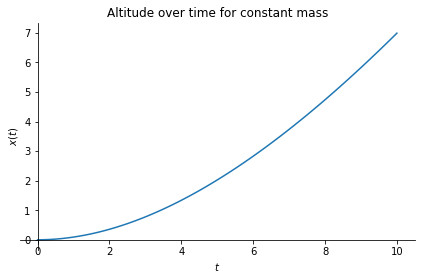

{F_t,max: 10, b: 0.1, g: 9.81, m: 1, x_0: 0, v_0: 0, alpha(t): 1}


Eq(x(t), 1.89999999999999*t + (19.0 - 19.0*exp(0.1*t))*exp(-0.1*t))

In [12]:
params = {F_t_max: 10, b: 0.1, g: 9.81, m: 1, x_0: 0, v_0: 0, a: 1}
model_soln_eval = model_soln.subs(params).doit()

sy.plotting.plot(
    model_soln_eval.rhs,
    (t, 0, 10),
    title="Altitude over time for constant mass",
    xlabel="$t$",
    ylabel="$x(t)$",
)
print(params)
display(model_soln_eval)

## Non-Constant Mass Model

More true to life is a non-constant mass model. The mass of the craft is depleted as fuel is consumed. We define the mass at any given time as:

\begin{equation}
    m(t) = m_\text{wet} - \int_{0}^{t} \gamma F_t(\tau) d\tau
\end{equation}

\begin{equation}
    F_t(t) = 
    \begin{cases}
        \alpha(t) F_{t,\text{max}} & m(t) > {m_\text{dry}} \\
        0 & m(t) \leq m_\text{dry}
    \end{cases}
\end{equation}

Where $m_\text{wet}$ is the initial or wet mass that includes the mass of the craft and its fuel, and $\gamma$ is the specific thrust (the mass loss rate per unit thrust).

In [7]:
# symbols
tau = sy.Symbol("tau", real=True, positive=True)  # alias for time
m_0 = sy.Symbol("m_0", real=True, positive=True)  # initial mass
gamma = sy.Symbol("gamma", real=True, positive=True)  # specific thrust

In [8]:
model_2 = model.subs(m, m_0 - sy.integrate(gamma * F_t.subs(t, tau), (tau, 0, t)))
display(model_2)

Eq(Derivative(x(t), (t, 2)), F_t,max*alpha(t)/(-gamma*Integral(F_t(tau), (tau, 0, t)) + m_0) - b*Derivative(x(t), t)/(-gamma*Integral(F_t(tau), (tau, 0, t)) + m_0) - g)

Solving yeilds:

In [9]:
model_2_soln = sy.dsolve(model_2, x, ics={x.subs(t, 0): x_0, x.diff(t).subs(t, 0): v_0})
display(model_2_soln)

NameError: name 'x_0' is not defined

In [ ]:
params_2 = {
    F_t: 10,
    b: 0.1,
    g: 9.81,
    m_0: 1,
    gamma: 0.1,
    x_0: 0,
    v_0: 0,
    F_t.subs(t, "_0"): 10,
}
model_2_soln_eval = model_2_soln.subs(params_2).doit()

print(params_2)
display(model_2_soln_eval)

TypeError: Invalid comparison of non-real zoo

In [ ]:
print(model_2_soln_eval)

Eq(x(t), 1.89999999999999*t - 18.9999999999999 + 18.9999999999999*exp(-0.1*t))


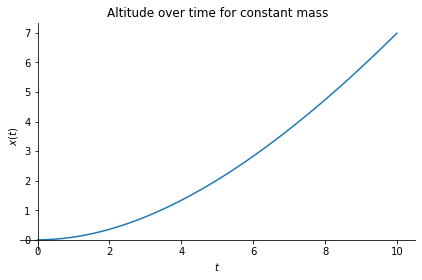

In [ ]:
sy.plotting.plot(
    model_2_soln_eval.rhs,
    (t, 0, 10),
    title="Altitude over time for constant mass",
    xlabel="$t$",
    ylabel="$x(t)$",
)